In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [3]:
data_path = 'archive.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


In [8]:
path = 'Data/test'
classes = os.listdir(path)
classes

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

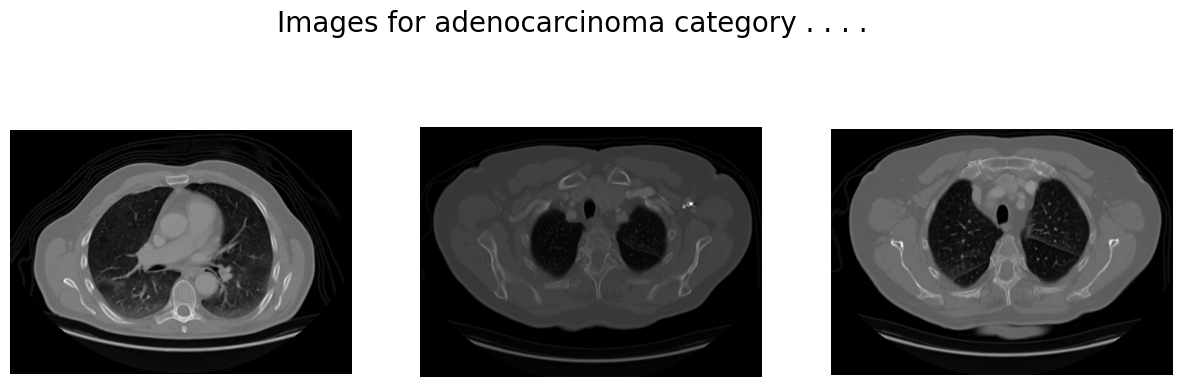

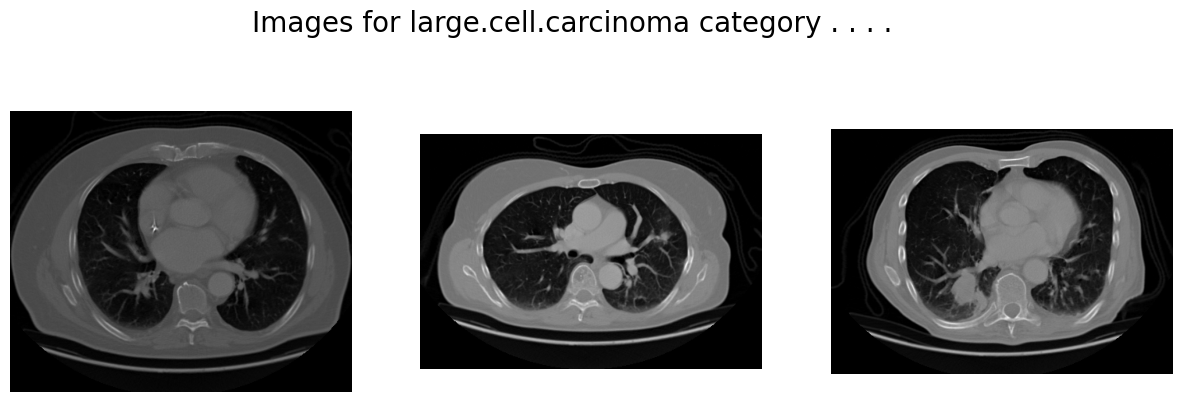

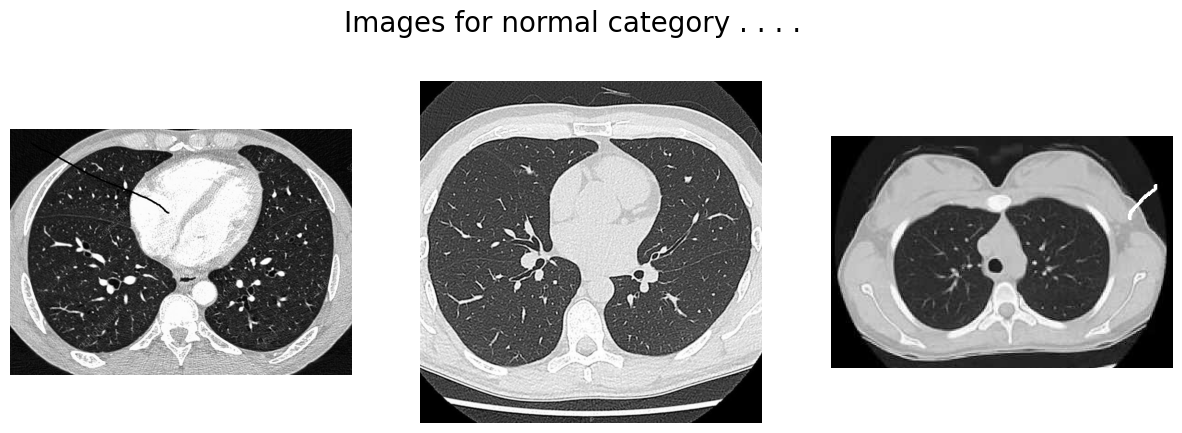

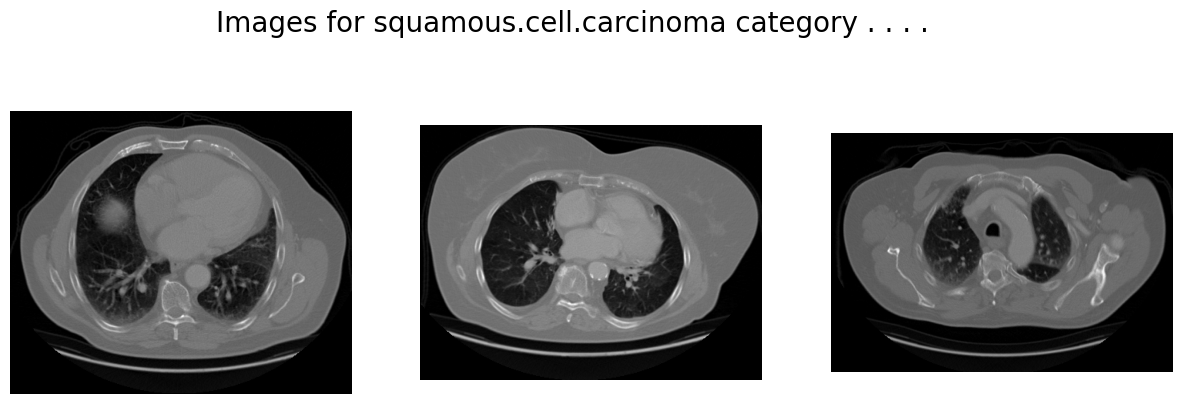

In [10]:
path = './Data/test'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [23]:
IMG_SIZE = 256

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.png')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_encoded_Y, test_size=0.3, random_state=0)

In [29]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,420 (128.50 MB)

 Trainable params: 33,683,652 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [30]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [33]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [35]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size = 64,
                    epochs = 100,
                    verbose = 1,
                    callbacks = early_stopping)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.6737 - val_loss: 0.8547
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.6526 - val_loss: 0.8566
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.6947 - val_loss: 0.7453
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7053 - val_loss: 0.6697
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.7789 - val_loss: 0.6061
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.8000 - val_loss: 0.5876
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.7684 - val_loss: 0.5906
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.7684 - val_loss: 0.5991
Epoch 9/

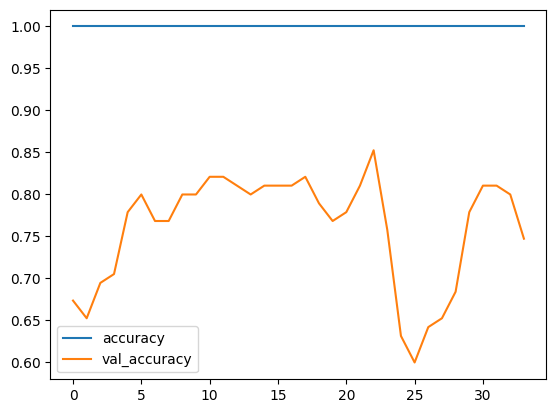

In [36]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [37]:
Y_pred = model.predict(X_test)
Y_val = np.argmax(y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.76      0.72      0.74        36
   large.cell.carcinoma       1.00      0.57      0.73        21
                 normal       1.00      1.00      1.00        12
squamous.cell.carcinoma       0.57      0.81      0.67        26

               accuracy                           0.75        95
              macro avg       0.83      0.78      0.78        95
           weighted avg       0.79      0.75      0.75        95



In [48]:
mod=tf.keras.Model()
 
# assign location
# path='lung_cancer_predction.h5'
 
# save
mod.save('lung_cancer_predction.h5')